In [181]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from adjustText import adjust_text
from matplotlib import gridspec
%matplotlib inline

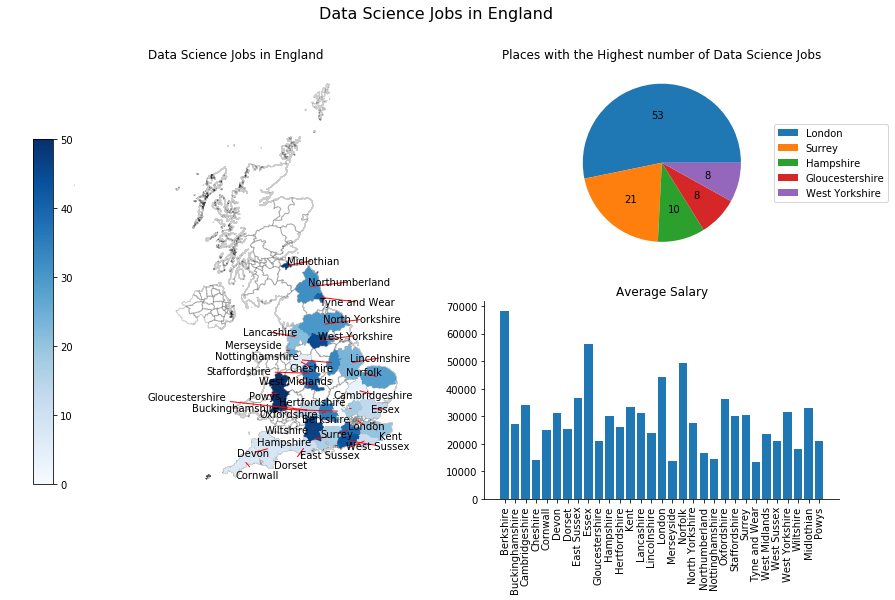

In [205]:
def lookup(county):
    # place the info from the data_sci dataframe into the shp geodataframe
    for row in data_sci.itertuples():
        if county in row.state:
            return [getattr(row,"mean"), getattr(row,"count")]
    else:
        return 'N/A'



def get_num(row):
    #changing all salary into a year number
    numbers = row.split()
    for i in range(len(numbers)):
        num = float(numbers[i])
        if num < 50:
            numbers[i] = (num * 7)* 260
        elif num < 500:
            numbers[i] = num * 260
            
    if len(numbers) == 0:
        return np.NaN
    elif len(numbers) == 1:
        return float(numbers[0])
    elif len(numbers) == 2:
        first = float(numbers[0])
        second = float(numbers[1])
        mean = (first + second)/ 2
        return float(mean)
    else:
        return "Problem"
    
    
# Get csv and shp files 
df = pd.read_csv(r"C:\Users\na\port\Geopanda MatplobLib\Job\reed_uk.csv")
map_df = gpd.read_file(r"C:\Users\na\port\Geopanda MatplobLib\Job\Shapefile\Map_UK.shp")
map_df = gpd.GeoDataFrame(map_df)

#Normailise Data
map_df = map_df[["NAME_2","geometry"]]
map_df["Compare"] = map_df["NAME_2"].str.upper() 
df['job_norm'] = df['job_title'].str.upper()

#split dataframe off to focus on data sci jobs
data_sci = df[(df['job_norm'].str.contains("DATA"))].copy()

#continue Normalising Data
data_sci["mean_salary"] = data_sci["salary_offered"].str.replace("‚¬|,|£|-|[a-z|A-Z]*","")
data_sci["mean_salary"] = data_sci["mean_salary"].apply(lambda x: get_num(x))
data_sci = data_sci.dropna()
data_sci["state"] = data_sci["state"].str.upper()

# Group the jobs by their county 
data_sci = data_sci.groupby('state')["mean_salary"].agg(["mean","count"])
data_sci = data_sci.reset_index()

#maps the salary and job nums onto the shp file. Use vectorisation to cut down on the number of records needed for loop 
map_df["Bool"] = map_df.Compare.isin(data_sci.state)
map_df_data_jobs = map_df[map_df["Bool"] == True].copy()
map_df_data_jobs["Info"] = map_df_data_jobs["Compare"].apply(lookup)

# splits up the info from the function into their own col
map_df_data_jobs["Av_Income"] = map_df_data_jobs.Info.apply(lambda x : x[0])
map_df_data_jobs["Job_Num"] = map_df_data_jobs.Info.apply(lambda x : x[1])



#create figure with 4 placeholder 
fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(2,2)
ax = plt.subplot(gs[:,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,1])
fig.suptitle("Data Science Jobs in England",fontsize=16)



# puts text in list for adjusttext function 
texts = []
for x,y,label in zip(map_df_data_jobs["geometry"].centroid.x, map_df_data_jobs["geometry"].centroid.y,map_df_data_jobs["NAME_2"]):
    texts.append(ax.text(x,y,label))

ax.axis("off")
base = map_df.plot( ax=ax, color = "white", edgecolor = "black" , alpha = 0.2)
overlap = map_df_data_jobs.plot(ax=ax, cmap="Blues" )
adjust_text(texts, ax=ax, lim=1000, text_from_points=True, text_from_text=True, autoalign=True,
        expand_text=(1, 1), expand_points=(1, 1), force_text=(0.01, 0.25), force_points=(0.01, 0.25),
        arrowprops=dict(arrowstyle='-', color='red', alpha=2))
ax.set_title("Data Science Jobs in England")
sm = plt.cm.ScalarMappable(cmap='Blues', norm= plt.Normalize(vmin=0,vmax =50))
sm._A = []

caxes = fig.add_axes([0.1,0.15,0.02,0.6])
colorbox = fig.colorbar(sm,cax=caxes)


# pie chart of 5 highest Job Num = ax3
pie_df = map_df_data_jobs.sort_values("Job_Num",ascending =False).head(5).copy()
ax2.set_title("Places with the Highest number of Data Science Jobs")
ax2.pie(pie_df["Job_Num"], autopct="%.0f")
ax2.legend(pie_df["NAME_2"], loc="center left", bbox_to_anchor = ([1.04,0.5]))


#bar chart of salary 
ax3.bar(map_df_data_jobs["NAME_2"],map_df_data_jobs["Av_Income"])
ax3.set_title("Average Salary")
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
for tick in ax3.get_xticklabels():
    tick.set_rotation(90)
